In [1]:
import torch
import gpytorch
from botorch.models import SingleTaskGP
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.transforms.outcome import Standardize
from gpytorch.kernels import ScaleKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.fit import fit_gpytorch_torch # fix Cholecky jitter error
from scipy.stats import norm
from sklearn.decomposition import PCA
import math 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
import os
import time

# config plot settings
plt.rcParams["font.size"] = 16

In [2]:
###
#  Load Data
###
file = h5py.File("targets_and_normalized_features.jld2", "r")
# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:]))
# simulation data
y = torch.from_numpy(np.transpose(file["gcmc_y"][:]))
# associated simulation costs
cost = torch.from_numpy(np.transpose(file["gcmc_elapsed_time"][:]))

# total number of COFs in data set
nb_COFs = X.shape[0] 

print("raw data - \n\tX:", X.shape)
print("\t\ty:", y.shape)
print("\t\tcost: ", cost.shape)    
    
print("\nEnsure features are normalized - ")
print("max:\n", torch.max(X, 0).values)
print("min:\n", torch.min(X, 0).values)

raw data - 
	X: torch.Size([608, 14])
		y: torch.Size([608])
		cost:  torch.Size([608])

Ensure features are normalized - 
max:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
min:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)


In [3]:
X_unsqueezed = X.unsqueeze(1)

## Helper Functions

#### Construct Initial Inputs

In [4]:
# make this into a .py file and import it as a module

In [5]:
# find COF closest to the center of feature space
def get_initializing_COF(X):
    # center of feature space
    feature_center = np.ones(X.shape[1]) * 0.5
    # max possible distance between normalized features
    return np.argmin(np.linalg.norm(X - feature_center, axis=1))

def diverse_set(X, train_size):
    # initialize with one random point; pick others in a max diverse fashion
    ids_train = [get_initializing_COF(X)]
    # select remaining training points
    for j in range(train_size - 1):
        # for each point in data set, compute its min dist to training set
        dist_to_train_set = np.linalg.norm(X - X[ids_train, None, :], axis=2)
        assert np.shape(dist_to_train_set) == (len(ids_train), nb_COFs)
        min_dist_to_a_training_pt = np.min(dist_to_train_set, axis=0)
        assert np.size(min_dist_to_a_training_pt) == nb_COFs
        
        # acquire point with max(min distance to train set) i.e. Furthest from train set
        ids_train.append(np.argmax(min_dist_to_a_training_pt))
    assert np.size(np.unique(ids_train)) == train_size # must be unique
    return np.array(ids_train)

In [6]:
# construct feature matrix of acquired points
def build_X_train(ids_acquired):
    return X[ids_acquired, :]

# construct output vector for acquired points
def build_y_train(ids_acquired):
    return y[ids_acquired].unsqueeze(-1)

# construct vector to track accumulated cost of acquired points
def build_cost(ids_acquired):
    return cost[ids_acquired]

#### Bayesian Algorithm

In [7]:
def run_Bayesian_optimization(nb_iterations, 
                              nb_COFs_initialization,
                              store_explore_exploit_terms=True):
    
    assert nb_iterations > nb_COFs_initialization
    ###
    #  Initialize system
    ###
    # select initial COFs for training data
    ids_acquired = diverse_set(X, nb_COFs_initialization)
    
    # track of exploration vs. exploitation terms 
    if store_explore_exploit_terms:
        explore_exploit_balance = np.array([(np.NaN, np.NaN) for i in range(nb_iterations)])
    
    # construct initial training sets
    X_train = build_X_train(ids_acquired)
    y_train = build_y_train(ids_acquired)
    # standardize outputs using *only currently acquired data*
    y_train = (y_train - torch.mean(y_train)) / torch.std(y_train)
    
    ###
    #  itterate through remaining budget using BO
    ###
    for i in range(nb_COFs_initialization, nb_iterations):
        # construct and fit GP model
        model = SingleTaskGP(X_train, y_train)
        mll   = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll, optimizer=fit_gpytorch_torch)
#         fit_gpytorch_model(mll)
        
        
        # use Expected improvement acquisition function
        acq_fn   = ExpectedImprovement(model, best_f=y_train.max().item())
        acq_vals = acq_fn.forward(X.unsqueeze(1))
        # get the id for the COF with highest acquisition value currently not in training set
        ids_sorted_by_aquisition = acq_vals.argsort(descending=True)
        for id_max in ids_sorted_by_aquisition:
            if not id_max.item() in ids_acquired:
                id_max_acq = id_max.item()
                break
        ###
        #  acquire this COF
        ###
        ids_acquired = np.concatenate((ids_acquired, [id_max_acq]))
        
        ###
        #  Track explore-exploit values
        ###
        if store_explore_exploit_terms:
            y_mu = model.posterior(X_unsqueezed[id_max_acq]).mean.squeeze().detach().numpy()
            y_sigma = np.sqrt(model.posterior(X_unsqueezed[id_max_acq]).variance.squeeze().detach().numpy())
            y_max = y_train.max().item()
            
            z = (y_mu - y_max) / y_sigma
            explore_term = y_sigma * norm.pdf(z)
            exploit_term = (y_mu - y_max) * norm.cdf(z)
            # check against BO torch's EI.
            assert np.isclose(explore_term + exploit_term, acq_vals[id_max_acq].item())
            explore_exploit_balance[i] = (explore_term, exploit_term)
        
        ###
        #  update training data; start over to normalize properly
        ###
        X_train = build_X_train(ids_acquired)
        y_train = build_y_train(ids_acquired)
        # standardize outputs using *only currently acquired data*
        y_train = (y_train - torch.mean(y_train)) / torch.std(y_train)
    
    # check budget constraint is stisfied
    assert np.size(ids_acquired) == nb_iterations
    assert len(np.unique(ids_acquired)) == nb_iterations
    return ids_acquired, explore_exploit_balance

# Run BO

In [8]:
nb_iterations = 100
nb_COFs_initialization = 3

ids_acquired, eeb = run_Bayesian_optimization(nb_iterations, nb_COFs_initialization)

y_acquired    = y[ids_acquired]
cost_acquired = build_cost(ids_acquired)

Iter 10/100: 2.531564513532533
Iter 20/100: 1.5977845202378844
Iter 30/100: 1.5336589625328543
Iter 40/100: 1.51033868842899
Iter 50/100: 1.4671705627878475
Iter 60/100: 1.464220585531776
Iter 10/100: 2.259921953527157
Iter 20/100: 1.536637681235032
Iter 30/100: 1.4498535831166488
Iter 40/100: 1.4296802200190513
Iter 10/100: 2.1090820609273804
Iter 20/100: 1.5259160914647434
Iter 30/100: 1.4413372951204615
Iter 40/100: 1.4416352305317908
Iter 10/100: 2.013532470167573
Iter 20/100: 1.5207324687563244
Iter 30/100: 1.432088136389039
Iter 40/100: 1.4002056503388152
Iter 10/100: 1.947059639754468
Iter 20/100: 1.5146320272437355
Iter 30/100: 1.4179314352311199
Iter 40/100: 1.3044569395438097
Iter 50/100: 1.2702834261229832
Iter 60/100: 1.2677354117770832
Iter 10/100: 1.8931670383400077
Iter 20/100: 1.5054804000377129
Iter 30/100: 1.4023125420516471
Iter 40/100: 1.2787566379596629
Iter 10/100: 1.8515727575576189
Iter 20/100: 1.495702794354195
Iter 30/100: 1.3897128402956949
Iter 40/100: 1.261

Iter 40/100: 1.3317985281071199
Iter 50/100: 1.2745021998661474
Iter 10/100: 1.5544282173498642
Iter 20/100: 1.42814242368641
Iter 30/100: 1.3735389679554801
Iter 40/100: 1.3283766242005621
Iter 50/100: 1.2763860074471782
Iter 10/100: 1.5545085095734337
Iter 20/100: 1.429481028420356
Iter 30/100: 1.3772383832331472
Iter 40/100: 1.3350023591208837
Iter 50/100: 1.2862687760047056
Iter 10/100: 1.550886379445526
Iter 20/100: 1.4266198014836224
Iter 30/100: 1.372381239695518
Iter 40/100: 1.3279009500753272
Iter 50/100: 1.2779023531004052
Iter 10/100: 1.5478191657085805
Iter 20/100: 1.4241286033309188
Iter 30/100: 1.3679970871406435
Iter 40/100: 1.3216763313761233
Iter 50/100: 1.2713990423905173
Iter 10/100: 1.5468510399389437
Iter 20/100: 1.4241407196958789
Iter 30/100: 1.3685768341784155
Iter 40/100: 1.3229226450596767
Iter 50/100: 1.270449313566877
Iter 10/100: 1.5460451199229164
Iter 20/100: 1.4242959422888446
Iter 30/100: 1.3685091487025365
Iter 40/100: 1.3199422968046928
Iter 50/100: 1

Iter 100/100: 1.0817247007474433
Iter 10/100: 1.4917733277280418
Iter 20/100: 1.3789001210510903
Iter 30/100: 1.280952461234056
Iter 40/100: 1.1661480353757996
Iter 50/100: 1.1400375597901076
Iter 60/100: 1.0804899668183114
Iter 70/100: 1.0774190287995198
Iter 80/100: 1.0760297976121398
Iter 90/100: 1.0756568630337389
Iter 100/100: 1.075533181006402
Iter 10/100: 1.4903466471772315
Iter 20/100: 1.3773896207323155
Iter 30/100: 1.2779941345753338
Iter 40/100: 1.1639786967797014
Iter 50/100: 1.117217981322191
Iter 60/100: 1.071247317179467
Iter 70/100: 1.069018211823421
Iter 80/100: 1.0669380785314135
Iter 90/100: 1.0665912480453128
Iter 10/100: 1.489078757523891
Iter 20/100: 1.3760981933621332
Iter 30/100: 1.275463549975249
Iter 40/100: 1.1592664224360125
Iter 50/100: 1.0888335591496707
Iter 60/100: 1.065822749799846
Iter 70/100: 1.0634539624579573
Iter 80/100: 1.0612768453170065
Iter 90/100: 1.0608848164130125
Iter 100/100: 1.0607893895045049
Iter 10/100: 1.4880813733169993
Iter 20/100: 

In [9]:
top_cof = np.argmax(y_acquired == max(y))
top_cof_acc_cost = sum(cost_acquired[:top_cof]).item() # 10978.643530249596 w/o optimizer

print("iteration we acquire top COF = ", top_cof.item() + 1)
print("accumulated cost up to observation of top COF = ", top_cof_acc_cost, " [min]" )

iteration we acquire top COF =  22
accumulated cost up to observation of top COF =  6759.435011923313  [min]


In [10]:
###
#  Store SFBO results
###
sfbo_res = dict({'ids_acquired': ids_acquired,
                'y_acquired': y_acquired,
                'cost_acquired': cost_acquired
                })

with open('search_results/sfbo_results_with_EI.pkl', 'wb') as file:
    pickle.dump(sfbo_res, file)

# Random Search

In [11]:
nb_runs = 1000

rs_res = dict()
rs_res['ids_acquired'] = []
rs_res['cost_acquired'] = []

for r in range(nb_runs):
    rs_ids_acquired = np.random.choice(range(nb_COFs), replace=False, size=nb_iterations)
    rs_cost_acquired = build_cost(rs_ids_acquired)
    rs_res['ids_acquired'].append(rs_ids_acquired)
    rs_res['cost_acquired'].append(rs_cost_acquired)

In [12]:
# get y_max acquired up to iteration i for i = 1,2,...
def y_max(res, key='ids_acquired'):
    y_max_mu      = np.zeros(nb_iterations)
    y_max_sig_bot = np.zeros(nb_iterations)
    y_max_sig_top = np.zeros(nb_iterations)
    
    for i in range(1, nb_iterations+1):
        # max value acquired up to this point
        y_maxes = np.array([max(y[res[key][r]][:i]) for r in range(nb_runs)])
        assert np.size(y_maxes) == nb_runs
        y_max_mu[i-1]      = np.mean(y_maxes)
        y_max_sig_bot[i-1] = np.std(y_maxes[y_maxes < y_max_mu[i-1]])
        y_max_sig_top[i-1] = np.std(y_maxes[y_maxes > y_max_mu[i-1]])
    return y_max_mu, y_max_sig_bot, y_max_sig_top

# rs_mean, rs_lower_bound, rs_upper_bound = y_max(rs_res)
y_rs_max_mu, y_rs_max_sig_bot, y_rs_max_sig_top = y_max(rs_res)

In [13]:
# y_rs_max_mu, y_rs_max_sig_bot, y_rs_max_sig_top = y_max(rs_res, key='cost_acquired')

In [14]:
###
#  Store Random Search Results
###
random_search_results = dict({'ids_acquired': rs_res['ids_acquired'],
                             'y_rs_max_mu': y_rs_max_mu,
                             'y_rs_max_sig_bot': y_rs_max_sig_bot,
                             'y_rs_max_sig_top': y_rs_max_sig_top,
                             'cost_acquired': rs_res['cost_acquired']
                             })

with open('search_results/random_search_results.pkl', 'wb') as file:
    pickle.dump(random_search_results, file)

# Plots

#### Search Efficiency and Cost Analysis

In [15]:
y_max = np.zeros(nb_iterations)
accumulated_cost = np.zeros(nb_iterations)
    
for i in range(1, nb_iterations+1):
    # accumulated cost
    accumulated_cost[i-1] = sum(cost_acquired[:i])
    # max value acquired up to this point
    y_max[i-1] = max(y[ids_acquired[:i]])

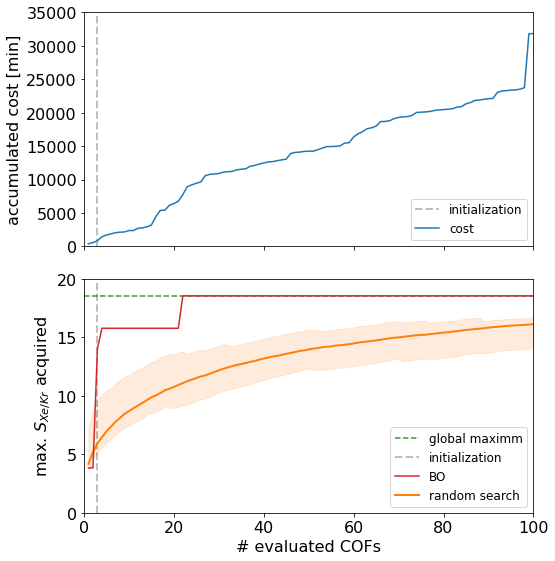

In [16]:
iterations = range(1, len(ids_acquired) + 1)

plt.figure(figsize=(8, 8))

ax1 = plt.subplot(2, 1, 1)
plt.axvline(x=nb_COFs_initialization, 
            label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)
plt.plot(iterations, accumulated_cost, label="cost", color="tab:blue")
plt.legend(fontsize=12)
plt.ylabel("accumulated cost [min]")
plt.xlim(xmin=0, xmax=nb_iterations)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylim(ymin=0, ymax=35000)

plt.subplot(2, 1, 2, sharex=ax1)
plt.axhline(y=max(y), label="global maximm", color="tab:green", ls="--", lw=1.5)
plt.axvline(x=nb_COFs_initialization, label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)
plt.plot(iterations, y_max, label="BO", color="tab:red", zorder=3)

plt.plot(iterations, y_rs_max_mu, label="random search", color="tab:orange", lw=2)
plt.fill_between(iterations, y_rs_max_mu - y_rs_max_sig_bot, y_rs_max_mu + y_rs_max_sig_top, 
    color="tab:orange", alpha=0.15)
plt.ylim(ymin=0, ymax=20)
plt.xlabel("# evaluated COFs")
plt.ylabel("max. $S_{Xe/Kr}$ acquired")

plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig("figs/SFBO_search_efficientcy_curve_with_optimizer.pdf", dpi=600, format="pdf")
plt.show()